In [95]:
import qiskit
import time
from matplotlib import pyplot as plt
from qiskit import IBMQ
import numpy as np
from qiskit import*



In [97]:

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [131]:
# Function to construct basis vectors
def basisF(bKey, bDict):
    
    p1, p2, p3 = bDict[bKey]
    
    if p1 == 1:
        v1 = [1,0]
    else:
        v1 = [0,1]
        
    if p2 == 1:
        v2 = [1,0]
    else:
        v2 = [0,1]
        
    if p3 == 1:
        v3 = [1,0]
    else:
        v3 = [0,1]
    
    return np.kron(np.kron(v1, v2), v3)

In [132]:
def exp_n3(counts,tot_counts, J):
    # Calculate the expectations for n = 3
    I = np.identity((2))
    X = [[0,1],[1,0]]
    Z = [[1,0],[0,-1]]
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))

    # Hc is diagonal
    Hc = J[0]*np.dot(z1,z2)+J[1]*np.dot(z2,z3)+J[2]*np.dot(z1,z3)
#     Hc = z3
    
    # Basis dict
    basisDict = {'000': [0,0,0], '010': [0,1,0], '001': [0,0,1], '101': [1,0,1], '110': [1,1,0], '100': [1,0,0], '011': [0,1,1], '111': [1,1,1]}
    
#     state = np.empty((2**n))
    cont = 0
    exptI = 0.0
    state = np.zeros((8,))
    for i in counts.keys():
#         state[cont] = (counts[i]/tot_counts)**1
        basisVec = basisF(i, basisDict)
        thisState = np.sqrt(counts[i]/tot_counts)*basisVec
        state = state + thisState
        exptI = exptI + (counts[i]/tot_counts)*np.matmul( np.transpose(basisVec), np.matmul(Hc, basisVec))
        cont = cont+1
    
#     print(exptI)
#     basisVec = basisF('110', basisDict)
#     print( np.matmul( np.transpose(basisVec), np.matmul(Hc, basisVec)) )
        
    # Compute expectation
    expt = np.matmul( np.transpose(state), np.matmul(Hc, state))

#     return np.sum(np.dot(Hc,state))
    return expt

# print(exp_n3(counts,tot_counts,J))

In [133]:
# QAOA body 
from qiskit.tools.monitor import job_monitor

def qaoa_counts(n, J, h, tot_counts, beta, gamma,p): 
    
    
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)

    circuit = QuantumCircuit(qr, cr)

    if (p == 1):
        
        # Add a H gate on all qubits
        for i in range(n):
            circuit.h(qr[i])

        # apply U(gamma)

        for i in range(n-1):
            circuit.cx(qr[i], qr[i+1])
            circuit.rz(2*gamma*J[i], qr[i+1])
            circuit.cx(qr[i], qr[i+1])

        # last one n loops to n=0
        circuit.cx(qr[n-1], qr[0])
        circuit.rz(2*gamma*J[0], qr[0])
        circuit.cx(qr[n-1], qr[0])

        # apply U(beta)
        for i in range(n):
            circuit.rx(2*gamma*h[i],qr[i])
            circuit.rx(2*beta,qr[i])
    
    else: 
        
        # Add an H gate on all qubits (just once not every p)
        for i in range(n):
            circuit.h(qr[i])
        
        # apply U(gamma) and then U(beta) succesively 
        for k in range(p):

            # apply U(gamma)

            for i in range(n-1):
                circuit.cx(qr[i], qr[i+1])
                circuit.rz(2*gamma[k]*J[i], qr[i+1])
                circuit.cx(qr[i], qr[i+1])

            # last one n loops to n=0
            circuit.cx(qr[n-1], qr[0])
            circuit.rz(2*gamma[k]*J[0], qr[0])
            circuit.cx(qr[n-1], qr[0])

            
            # apply U(beta)
            for i in range(n):
                circuit.rx(2*gamma[k]*h[i],qr[i])
                circuit.rx(2*beta[k],qr[i])


    circuit.measure(qr,cr)
    
    # Run on Yorktown
#     provider = IBMQ.get_provider(hub='ibm-q-community', group='ug-projects', project='princeton-tureci')
#     qcomp = provider.get_backend('ibmq_ourense')
#     qcomp = provider.get_backend('ibmq_vigo')

    

    
    provider = IBMQ.get_provider('ibm-q')
    qcomp = provider.get_backend('ibmq_5_yorktown')
    #simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(circuit,backend=qcomp)
    
    job_monitor(job)
    
    result = job.result()
    
    counts = result.get_counts(circuit)

    plot_histogram(counts)

#     tot_counts = 1000
#     result = execute(circuit, simulator, shots=tot_counts).result()

    return counts


In [134]:
# QAOA function for a given p for now

def qaoa_n3(samples, anglesRandom,J,p):
    n = 3
    res = np.empty(samples) 
    
    if (p == 1):
        beta_res = np.empty((samples))
        gamma_res = np.empty((samples))
    else:
        beta_res = np.empty((samples,p))
        gamma_res = np.empty((samples,p))

    
    # number of shots to run
    tot_counts = 1000
    
    # normal sample fo h 
    h = np.random.uniform(0, 1, n)

    for i in range(n):
#         J[i] = -1 
        h[i] = 0
    
    if (anglesRandom == False and p == 1):
        # step to make exactly samples number of samples
        # input samples should be a perfect square
        size_m = np.sqrt(samples)
        beta = np.linspace(0,np.pi*2, size_m)
        gamma = np.linspace(0,np.pi*2, size_m)
        
        for i in range(beta.shape[0]):
            for j in range(gamma.shape[0]):
                k = beta.shape[0]*i+j
                counts = qaoa_counts(n,J,h,tot_counts,beta[i],gamma[i],p)
                res[k] = exp_n3(counts,tot_counts,J)
                beta_res[k] = beta[i]
                gamma_res[k] = gamma[j]
       
    else:
        
        for k in range(samples):

            beta = np.random.uniform(0, np.pi/2, p)
            gamma = np.random.uniform(0, np.pi*2, p)
            
            counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
            res[k] = exp_n3(counts,tot_counts,J)
            
            if (p == 1):
                beta_res[k] = beta
                gamma_res[k] = gamma
            else: 
                beta_res[k,:] = beta
                gamma_res[k,:] = gamma

    
    return res,beta_res,gamma_res

Job Status: job has successfully run


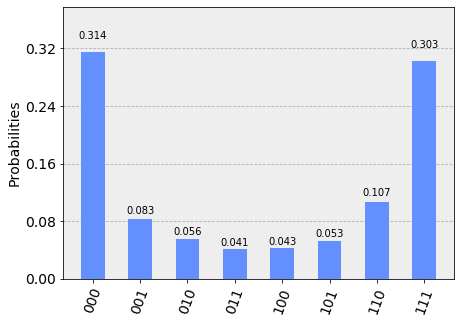

In [93]:
# For J = [-1,-1,-1] and gamma = 0.829, beta = 0.729

from qiskit.visualization import plot_histogram
counts = qaoa_counts(3,[-1,-1,-1],[0,0,0],1000, [0.3686599, 0.77223737, 1.41098704, 1.56135136], [1.33134074, 0.94943944, 5.2386772, 2.08326546],4)
plot_histogram(counts)


In [214]:
# Now do miniziation 
J = [1,0.6,0.3]
p = 1
def qaoa_expect(angles):
    beta = angles[:p]
    gamma = angles[p:]

    n,h,tot_counts = 3,[0,0,0],1000
    counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
    return exp_n3(counts,tot_counts,J)

In [215]:
from scipy.optimize import minimize

# Run 10 samples, obtain first optimal min for beta gamma, then run again to obtain a better min
p = 1
# run with random angles
# try 10 samples to find a good guess due to QPU ressources
res,beta_res,gamma_res = qaoa_n3(20, True,J,p)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [216]:
imin_first = np.argmin(res)
beta_first = beta_res[imin_first]
gamma_first = gamma_res[imin_first]

# guesses = np.empty((2,p))
# guesses[0,:] = beta_first
# guesses[1,:] = gamma_first

guesses = np.empty((2*p))
guesses[:p] = beta_first
guesses[p:] = gamma_first

In [173]:
# Optimize objective funciton with the first guesses
mm = minimize(qaoa_expect,guesses, method='BFGS')

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job is queued (4)       

KeyboardInterrupt: 

In [171]:
print(mm)

      fun: -0.38899999999999996
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([7113539.584,  738197.504])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 104
      nit: 0
     njev: 23
   status: 2
  success: False
        x: array([0.29960102, 3.48322681])


In [218]:
print(qaoa_expect(guesses))

Job Status: job has successfully run
-0.18399999999999997


In [217]:
print(guesses)

[1.05946275 0.30077251]
